In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
import copy
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


In [9]:
with open('train-1.renju') as f:
    content = f.readlines()
data = [x.strip() for x in content] 

' '.join(list(filter(lambda a: 'p' not in a, data[34])))

f = open('renju-mod', 'w')
for elem in data:
    list(filter(lambda a: 'p' not in a, elem))
    f.write(' '.join(list(filter(lambda a: 'p' not in a, elem))) +'\n')  # python will convert \n to os.linesep
f.close()

In [10]:
def get_number(letter):
    #lst = {'a':0, 'b':1,}

    return ord(letter) - ord('a')

def get_pos(elem):
    w = get_number(elem[0])
    h = int(elem[1:]) - 1
    return w, h

In [11]:
test_data = data[int(0.7 * len(data)):]

In [12]:
data = data[: int(0.7 * len(data))]

In [6]:
import multiprocessing as mp
def parallel_game(_):
    elem = data[np.random.randint(len(data))]
    cur_pos = np.zeros((15,15, 3))
    game = elem.split()
    for iterator in range(1, len(game) - 1):
        elem = game[iterator]
        w, h = get_pos(elem)
        if iterator % 2 == 1:
            cur_pos[w][h][0] = 1 
        else:
            cur_pos[w][h][1] = 1


        for i in range(15):
            for j in range(15):
                if cur_pos[i][j][0] > 0:
                    cur_pos[i][j][2] += 1
                if cur_pos[i][j][1] > 0:
                    cur_pos[i][j][2] += 1


        cur_pos_to_app = copy.deepcopy(cur_pos)
        w, h = get_pos(game[iterator + 1])
        ans = h * 15 + w
        #print(cur_pos)
        return (cur_pos_to_app, ans)

In [7]:
from itertools import islice
def data_gen_mp(data, test=False):
    if test == False:
        part_size = len(data)//30
    else:
        part_size = len(data)//255
    cpu = mp.cpu_count()
    pool = mp.Pool(processes=cpu)
    args = [None] * cpu
    while(1):
        neural_games = []
        neural_ans = []
        
        while(len(neural_games) < part_size):
            results = pool.map(parallel_game,  args)
            
            #print('Ext')
            
            for elem in results:
                if elem is not None:
                    neural_games.append(elem[0])
                    neural_ans.append(elem[1])
            
            
            if (len(neural_games) >= part_size):
                break
            
        neural_games = np.array(neural_games)
        neural_ans = np.array(neural_ans)
        neural_ans = label_binarize(neural_ans, classes=[i for i in range(225)])
        neural_games.resize((len(neural_games), 1, 15,15,3))
        pool.close()
        yield [neural_games, neural_ans]

In [13]:
from itertools import islice
def data_gen(data, test=False):
    part_size = len(data)//30
    while(1):
        neural_games = []
        neural_ans = []
        while(len(neural_games) < part_size):
            elem = data[np.random.randint(len(data))]
            cur_pos = np.zeros((15,15, 3))
            game = elem.split()
            for iterator in range(1, len(game) - 1):
                elem = game[iterator]
                w, h = get_pos(elem)
                if iterator % 2 == 1:
                    cur_pos[w][h][0] = 1 
                else:
                    cur_pos[w][h][1] = 1 
                
                cur_pos[:, :, 2:] = cur_pos.sum(2).reshape((15,15,1))
                        
                
                
                if iterator % 2 == 1:
                    cur_pos_to_app = copy.deepcopy(cur_pos)
                    w, h = get_pos(game[iterator + 1])
                    ans = h * 15 + w
                    #print(cur_pos)

                    neural_ans.append(ans)
                    neural_games.append(cur_pos_to_app)
                    if (len(neural_games) >= part_size):
                        break


        neural_games = np.array(neural_games)
        neural_ans = np.array(neural_ans)
        neural_ans = label_binarize(neural_ans, classes=[i for i in range(225)])
        neural_games.resize((len(neural_games), 1, 15,15,3))
        yield (neural_games, neural_ans)

In [65]:
model_policy.save("policy")

In [101]:
from itertools import islice
def data_gen_lr(data, test=False):
    part_size = len(data) // 4100
    while(1):
        neural_games = []
        neural_ans = []
        while(len(neural_games) < part_size):
            elem = data[np.random.randint(len(data))]
            cur_pos = np.zeros(225)
            game = elem.split()
            for iterator in range(1, len(game) - 1):
                elem = game[iterator]
                w, h = get_pos(elem)
                if iterator % 2 == 1:
                    cur_pos[h * 15 + w] = 1 
                else:
                    cur_pos[h * 15 + w] = 2 
                
                cur_pos_to_app = copy.deepcopy(cur_pos)
                w, h = get_pos(game[iterator + 1])
                ans = h * 15 + w
                #print(cur_pos)
                neural_ans.append(ans)
                neural_games.append(cur_pos_to_app)
                if (len(neural_games) >= part_size):
                    break


        neural_games = np.array(neural_games)
        neural_ans = np.array(neural_ans)
        #neural_ans = label_binarize(neural_ans, classes=[i for i in range(225)])
        #neural_games.resize((part_size, 1, 15,15,3))
        yield (neural_games, neural_ans)

In [107]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
#clf = LinearRegression(n_jobs=8)
#clf = KNeighborsClassifier(n_jobs = 4, n_neighbors=3)
clf = LogisticRegression(n_jobs = 8)
#clf = Ridge()

X, y = next(data_gen_lr(data))
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=8,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [154]:
%%timeit
s = clf.predict([tester_1.lr_pos])[0]

21.7 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [189]:
%%timeit
random.randint(0,224)

979 ns ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [190]:
%%timeit
np.random.randint(0,224)

1.26 µs ± 19.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [108]:
from sklearn.externals import joblib
filename = 'LinearClass'
_ = joblib.dump(clf, filename, compress=9)

In [46]:
from sklearn.externals import joblib
clf = joblib.load('LinearClass')

In [65]:
clf.predict(X_test).shape

(14522,)

In [66]:
y_true.shape

(14522,)

In [68]:
clf.predict(X_test)[0]

109.37090301513672

In [184]:
from sklearn.metrics import accuracy_score
X_test, y_true = next(data_gen_lr(test_data))
y_pred = clf.predict(X_test)
for i in range(len(y_pred)):
    y_pred[i] = int(y_pred[i])
    
""" 
for elem in clf.predict(X_test):
    if elem > int(elem) + 0.5:
        y_pred.append(int(elem) + 1)
    else:
        y_pred.append(int(elem))
"""        
accuracy_score(y_true, y_pred)

0.020689655172413793

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Convolution2D, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.layers import GRU, LSTM

model_policy = Sequential()

model_policy.add(Reshape((15,15,3), input_shape=(1,15,15,3)))
model_policy.add(Convolution2D(4, (5,5), activation='relu'))
model_policy.add(BatchNormalization())
model_policy.add(Convolution2D(8, (5,5), activation='relu'))
model_policy.add(Convolution2D(16, (3,3), activation='relu'))
model_policy.add(BatchNormalization())
model_policy.add(Convolution2D(32, (3,3), activation='relu'))

model_policy.add(Flatten(name='flatten'))


model_policy.add(Dense(1100, activation='relu', name='fczero'))
model_policy.add(BatchNormalization())
model_policy.add(Dense(550, activation='relu', name='fc1'))
model_policy.add(Dropout(0.1))
model_policy.add(Dense(225, activation='softmax', name='fc2'))
model_policy.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model_policy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 15, 15, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 4)         304       
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 4)         16        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           808       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 16)          1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 16)          64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 32)          4640      
__________

In [9]:
model_policy.load_weights("weights.11-0.283181.hdf5")

In [14]:
from keras.models import load_model
model_policy = load_model("zeros_policy_44")
model = model_policy

In [52]:
for iteration in range(1000):
    neural_games, neural_ans = next(data_gen(data))
    model_policy.fit(neural_games, neural_ans, batch_size=20096, epochs=100, verbose=2,
                    callbacks=[model_saver, tensorboard], #TQDMNotebookCallback()],
                     validation_data = next(data_gen(test_data, test=False)))

Train on 46309 samples, validate on 19846 samples
Epoch 1/100
1s - loss: 2.1883 - acc: 0.4262 - val_loss: 2.2348 - val_acc: 0.4338
Epoch 2/100
1s - loss: 2.1722 - acc: 0.4303 - val_loss: 2.2318 - val_acc: 0.4348
Epoch 3/100
1s - loss: 2.1579 - acc: 0.4341 - val_loss: 2.2337 - val_acc: 0.4338
Epoch 4/100
1s - loss: 2.1490 - acc: 0.4350 - val_loss: 2.2485 - val_acc: 0.4316
Epoch 5/100
1s - loss: 2.1436 - acc: 0.4339 - val_loss: 2.2527 - val_acc: 0.4321
Epoch 6/100
1s - loss: 2.1408 - acc: 0.4360 - val_loss: 2.2499 - val_acc: 0.4311
Epoch 7/100
1s - loss: 2.1347 - acc: 0.4395 - val_loss: 2.2570 - val_acc: 0.4314
Epoch 8/100
1s - loss: 2.1284 - acc: 0.4404 - val_loss: 2.2594 - val_acc: 0.4298
Epoch 9/100
1s - loss: 2.1202 - acc: 0.4403 - val_loss: 2.2556 - val_acc: 0.4313
Epoch 10/100
1s - loss: 2.1152 - acc: 0.4420 - val_loss: 2.2557 - val_acc: 0.4313
Epoch 11/100
1s - loss: 2.1138 - acc: 0.4437 - val_loss: 2.2627 - val_acc: 0.4317
Epoch 12/100
1s - loss: 2.1129 - acc: 0.4425 - val_loss: 

KeyboardInterrupt: 

In [11]:
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback, TQDMCallback
# keras, model definition...
model_saver = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.6f}.hdf5",
                                              monitor='val_acc', verbose=0,
                                              save_best_only=True, save_weights_only=False,
                                              mode='auto')
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', 
                                          histogram_freq=0, 
                                          write_graph=True,
                                          write_images=True)

In [53]:
model_policy.save('zeros_policy_44')

In [ ]:
2 + 2

In [11]:
model_policy.fit_generator(data_gen(data, True),
        steps_per_epoch=500, epochs=350, verbose=0,
                   validation_data = data_gen(test_data, test=True), validation_steps=2,
                   callbacks=[model_saver, tensorboard, TQDMNotebookCallback()])

ResourceExhaustedError: OOM when allocating tensor with shape[72,2200]
	 [[Node: Variable_15/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_15"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_15, Const_21)]]

Caused by op 'Variable_15/Assign', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/axcel/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/axcel/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/axcel/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/axcel/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/axcel/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/axcel/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/axcel/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/axcel/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/axcel/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/axcel/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/axcel/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/axcel/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-965bb7b58cb9>", line 5, in <module>
    callbacks=[model_saver, tensorboard, TQDMNotebookCallback()])
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/models.py", line 1097, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/engine/training.py", line 1774, in fit_generator
    self._make_train_function()
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/engine/training.py", line 1001, in _make_train_function
    self.total_loss)
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/optimizers.py", line 393, in get_updates
    ms = [K.zeros(shape) for shape in shapes]
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/optimizers.py", line 393, in <listcomp>
    ms = [K.zeros(shape) for shape in shapes]
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 520, in zeros
    dtype, name)
  File "/home/axcel/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 286, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/home/axcel/.local/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/home/axcel/.local/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 305, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/axcel/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/home/axcel/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/axcel/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/axcel/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[72,2200]
	 [[Node: Variable_15/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_15"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_15, Const_21)]]


In [85]:
model_policy.save("policy")

In [13]:
from keras.models import load_model
model_check_env = load_model("ReshapedModelsmall")

In [10]:
from keras.models import load_model, save_model

#save_model(model, "med_modelv1")

In [13]:
model_policy.load_weights("weights.04-0.400417.hdf5")

In [11]:
model = load_model("weights.11-0.283181.hdf5")

In [15]:
model_policy = load_model("ReshapedModel0.46-9")

In [16]:
model = load_model("Med5")

In [31]:
model.load_weights("weights.18-0.381543.hdf5")

In [209]:
from keras.models import load_model
from sklearn.externals import joblib


#clf = joblib.load('LinearClass')

#model = load_model('zeros_policy_44')

class RenjuTEST(object): 
    def __init__(self, player, mode):
        """
        player : 1 for black, 2 for white
        """
        self.cur_pos = np.zeros((15,15, 3))
        self.cur_player = 1
        self.player = player
        self.action_space = 225
        self.moves_done = 0
        self.ext_pos = np.zeros((25, 25))
        self.lr_pos = np.zeros(225)
        self.mode = mode
        self.obl_action = None
        self.win_action = None
        
        
    def in_step(self, action):
        """
        Run one timestep of the environment's dynamics. When end of episode
        is reached, reset() should be called to reset the environment's internal state.
        Input
        -----
        action : an action provided by the environment
        Outputs
        -------
        (observation, reward, done, info)
        observation : agent's observation of the current environment
        reward [Float] : amount of reward due to the previous action
        done : a boolean, indicating whether the episode has ended
        info : a dictionary containing other diagnostic information from the previous action
        """
        self.moves_done += 1
        if self.cur_player == 1:
            self.cur_pos[action % 15][action // 15][0] = 1
            self.lr_pos[action] = 1
        else:
            self.cur_pos[action % 15][action // 15][1] = 1
            self.lr_pos[action] = 2
            
            
            
        w = (action % 15) + 5
        h = (action // 15) + 5
        
        self.ext_pos[w][h] = self.cur_player
        
        """
        for i in range(15):
            for j in range(15):
                if self.cur_pos[i][j][0] > 0 or self.cur_pos[i][j][1] > 0:
                    self.cur_pos[i][j][2] += 1
        """
        
        
        self.cur_pos[:, :, 2:] = self.cur_pos.sum(2).reshape((15,15,1))
        
        reward = 0
        
        rdiag = [0, 0, 0]
        rdiaginv = [0, 0, 0]
        ldiag = [0, 0, 0]
        ldiaginv = [0, 0, 0]
        rrow = [0, 0, 0]
        lrow = [0, 0, 0]
        rcol = [0, 0, 0]
        lcol = [0, 0, 0]
        
        broken = [0,0,0,0,0,0,0,0]
        
        for i in range(5):
            
            if self.ext_pos[w + i][h + i]:
                if not broken[0]:
                    rdiag[int(self.ext_pos[w + i][h + i])] += 1
                else:
                    broken[0] = 1
                
            if self.ext_pos[w][h + i]:
                if not broken[1]:
                    rcol[int(self.ext_pos[w][h + i])] += 1
                else:
                    broken[1] = 1
                
            if self.ext_pos[w - i][h + i]:
                if not broken[2]:
                    ldiag[int(self.ext_pos[w - i][h + i])] += 1
                else:
                    broken[2] = 1
                
            
            if self.ext_pos[w - i][h]:
                if not broken[3]:
                    lrow[int(self.ext_pos[w - i][h])] += 1
                else:
                    broken[3] = 1
            
            if self.ext_pos[w - i][h - i]:
                if not broken[4]:
                    rdiaginv[int(self.ext_pos[w - i][h - i])] += 1
                else:
                    broken[4] = 1
            
            if self.ext_pos[w][h - i]:
                if not broken[5]:
                    lcol[int(self.ext_pos[w][h - i])] += 1
                else:
                    broken[5] = 1
            
            if self.ext_pos[w + i][h - i]:
                if not broken[6]:
                    ldiaginv[int(self.ext_pos[w + i][h - i])] += 1
                else:
                    broken[6] = 1
            
            if self.ext_pos[w + i][h]:
                if not broken[7]:
                    rrow[int(self.ext_pos[w + i][h])] += 1
                else:
                    broken[7] = 1
                    
        
        self.obl_action = None
        first_obl_action = None
        second_obl_action = None
        
        rightdiag = rdiag[self.cur_player] + rdiaginv[self.cur_player]
        
        if rightdiag >= 4:
            if rightdiag >= 6:
                if self.player == self.cur_player:
                    reward = 1
                else:
                    reward = -1
            else:
                if (self.ext_pos[w + rdiag[self.cur_player]][h + rdiag[self.cur_player]] == 0 and 
                 0 <= w - 5 + rdiag[self.cur_player] < 15 and 0 <= h - 5 + rdiag[self.cur_player] <= 15):
                    first_obl_action = (h - 5 + rdiag[self.cur_player]) * 15 + w - 5 + rdiag[self.cur_player]
                
                if (self.ext_pos[w - rdiaginv[self.cur_player]][h - rdiaginv[self.cur_player]] == 0 and 
                 0 <= w - 5 - rdiaginv[self.cur_player] < 15 and 0 <= h - 5 - rdiaginv[self.cur_player] <= 15):
                    second_obl_action = (h - 5 - rdiaginv[self.cur_player]) * 15 + w - 5 - rdiaginv[self.cur_player]
                
                if first_obl_action or second_obl_action:
                    if rightdiag == 5 and self.player == self.cur_player:
                        self.win_action = (first_obl_action, second_obl_action)
                    if first_obl_action:
                        self.obl_action = first_obl_action
                    else:
                        self.obl_action = second_obl_action
                    
                
                
            
        leftdiag = ldiag[self.cur_player] + ldiaginv[self.cur_player]
        
        if leftdiag >= 4:
            if leftdiag >= 6:
                if self.player == self.cur_player:
                    reward = 1
                else:
                    reward = -1
            else:
                if (self.ext_pos[w - ldiag[self.cur_player]][h + ldiag[self.cur_player]] == 0 and 
                 0 <= w - 5 - ldiag[self.cur_player] < 15 and 0 <= h - 5 + ldiag[self.cur_player] <= 15):
                    first_obl_action = (h - 5 + ldiag[self.cur_player]) * 15 + w - 5 - ldiag[self.cur_player]
                
                if (self.ext_pos[w + ldiaginv[self.cur_player]][h - ldiaginv[self.cur_player]] == 0 and 
                 0 <= w - 5 + ldiaginv[self.cur_player] < 15 and 0 <= h - 5 - ldiaginv[self.cur_player] <= 15):
                    second_obl_action = (h - 5 - ldiaginv[self.cur_player]) * 15 + w - 5 + ldiaginv[self.cur_player]
                
                if first_obl_action or second_obl_action:
                    if leftdiag == 5 and self.player == self.cur_player:
                        self.win_action = (first_obl_action, second_obl_action)
                    if first_obl_action:
                        self.obl_action = first_obl_action
                    else:
                        self.obl_action = second_obl_action
                    
        
        row = rrow[self.cur_player] + lrow[self.cur_player]
        
        if row >= 4:
            if row >= 6:
                if self.player == self.cur_player:
                    reward = 1
                else:
                    reward = -1
            else:
                if (self.ext_pos[w - lrow[self.cur_player]][h] == 0 and 
                 0 <= w - 5 - lrow[self.cur_player] < 15):
                    first_obl_action = (h - 5) * 15 + w - 5 - lrow[self.cur_player]
                
                if (self.ext_pos[w + rrow[self.cur_player]][h] == 0 and 
                 0 <= w - 5 + rrow[self.cur_player] < 15):
                    second_obl_action = (h - 5) * 15 + w - 5 + rrow[self.cur_player]
                
                if first_obl_action or second_obl_action:
                    if row == 5 and self.player == self.cur_player:
                        self.win_action = (first_obl_action, second_obl_action)
                    if first_obl_action:
                        self.obl_action = first_obl_action
                    else:
                        self.obl_action = second_obl_action
                    
        
        
        col = lcol[self.cur_player] + rcol[self.cur_player]
        
        if col >= 4:
            if col >= 6:
                if self.player == self.cur_player:
                    reward = 1
                else:
                    reward = -1
            else:
                if (self.ext_pos[w][h - lcol[self.cur_player]] == 0 and 
                 0 <= h - 5 - lcol[self.cur_player] <= 15):
                    first_obl_action = (h - 5 - lcol[self.cur_player]) * 15 + w - 5
                
                if (self.ext_pos[w][h + rcol[self.cur_player]] == 0 and 
                 0 <= h - 5 + rcol[self.cur_player] <= 15):
                    second_obl_action = (h - 5 + rcol[self.cur_player]) * 15 + w - 5
                
                if first_obl_action or second_obl_action:
                    if col == 5 and self.player == self.cur_player:
                        self.win_action = (first_obl_action, second_obl_action)
                        
                    if first_obl_action:
                        self.obl_action = first_obl_action
                    else:
                        self.obl_action = second_obl_action
                    
                    
        #if self.win_action != None:
        #    print("WARNING, WIN POSITION:", self.win_action)
            
        #print("pure", first_obl_action, second_obl_action)
        #print(self.win_action)
        
        if self.cur_player == 1:
            self.cur_player = 2
        else:
            self.cur_player = 1
        
        done = True if (self.moves_done == 225 or reward != 0) else False
        cur_pos = self.cur_pos
        if self.moves_done == 225:
            self.reset()
        info = dict()
        return (cur_pos, reward, done, info)
    
    def net_ans(self, model, mode = 'all'):
        s = model.predict(np.array([[self.cur_pos]]))[0]
        if mode == 'one':
            return np.argmax(s)
        else:
            #return sorted(range(len(s)), key=lambda k: s[k], reverse=True)
            return np.argsort(s)
    
    def simulation(self, model, mode):
        fake_env = RenjuTEST(1, 'neural')
        fake_env.cur_pos = np.copy(self.cur_pos)
        fake_env.cur_player = self.cur_player
        fake_env.player = self.player
        fake_env.action_space = self.action_space = 225
        fake_env.moves_done = self.moves_done
        fake_env.ext_pos = np.copy(self.ext_pos)
        fake_env.lr_pos = np.copy(self.lr_pos)
        fake_env.mode = self.mode
        reward = 0
        while reward == 0:
            """
            action = random.randint(0,224)
            while fake_env.cur_pos[action % 15][action // 15][0] != 0 or fake_env.cur_pos[action % 15][action // 15][1] != 0:
                action = random.randint(0,224)
                
            """ 
            #if mode == 'kn':
            s = clf.predict_proba([fake_env.lr_pos])[0]
            #else:
            #    s = model.predict(np.array([[fake_env.cur_pos]]))[0]
            action = np.argmax(s)
            if fake_env.cur_pos[action % 15][action // 15][0] != 0 or fake_env.cur_pos[action % 15][action // 15][1] != 0:
                net_move = np.argsort(s)[::-1]
                action = 0
                for act in net_move:
                    if fake_env.cur_pos[act % 15][act // 15][0] == 0 and fake_env.cur_pos[act % 15][act // 15][1] == 0:
                        action = act
                        break
            #"""
            cur_pos, reward, done, info = fake_env.in_step(action)
            
        if reward == 1:
            return 1
        else:
            return 0
    

    
    def step(self, action, mode = 'kn'):
        cur_pos, reward, done, info = self.in_step(action)
        
        if self.win_action != None:
            #print("WIN ACTION")
            if self.win_action[0]:
                if self.ext_pos[(self.win_action[0] % 15) + 5][(self.win_action[0] // 15) + 5] == 0:
                    action = self.win_action[0]
                    cur_pos, reward, done, info = self.in_step(self.win_action[0])
                    return cur_pos, reward, done, action
            if self.win_action[1]:
                if self.ext_pos[(self.win_action[1] % 15) + 5][(self.win_action[1] // 15) + 5] == 0:
                    action = self.win_action[1]
                    cur_pos, reward, done, info = self.in_step(self.win_action[1])
                    return cur_pos, reward, done, action
            
        
        if self.obl_action:
            action = self.obl_action
            cur_pos, reward, done, info = self.in_step(self.obl_action)
            return cur_pos, reward, done, action
        
        if reward != 0:
            #self.render()
            if done:
                self.reset()
            return cur_pos, reward, done, info
        else:
            if self.mode == 'neural':
                s = model.predict(np.array([[self.cur_pos]]))[0]
            else:
                s = clf.predict_proba([self.lr_pos])[0]
            #plt.figure()
            #k = s.reshape((15,15))
            #plt.imshow(k, cmap='hot', interpolation='nearest')
            #plt.show()
            action = np.argmax(s)
            if self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
                net_move = np.argsort(s)[::-1]
                
                action = 0
                #print(net_move)
                for act in net_move:
                    if self.cur_pos[act % 15][act // 15][0] == 0 and self.cur_pos[act % 15][act // 15][1] == 0:
                        action = act
                        break
                #print("Net:", action)

            rnd = np.random.randint(1, 100)
            if rnd < -10:
                action = np.random.randint(0, 224)
                while self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
                    action = np.random.randint(0, 224)
            print('Net action:', action)
            cur_pos, reward, done, info = self.in_step(action)
            return cur_pos, reward, done, action
    
    def learning(self, opponent):
        if self.moves_done % 2 == 0:
            s = opponent.predict(np.array([[self.cur_pos]]))[0]
        else:
            s = model.predict(np.array([[self.cur_pos]]))[0]
        action = np.argmax(s)
        if self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
            net_move = np.argsort(s)[::-1]

            action = 0
            #print(net_move)
            for act in net_move:
                if self.cur_pos[act % 15][act // 15][0] == 0 and self.cur_pos[act % 15][act // 15][1] == 0:
                    action = act
                    break
            #print("Net:", action)
        rnd = np.random.randint(1, 100)
        if rnd < 5:
            action = np.random.randint(0, 224)
            while self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
                action = np.random.randint(0, 224)

        cur_pos, reward, done, info = self.in_step(action)
        return cur_pos, reward, done, action
            
            
    
    def render(self, mode='human'):
        if mode == 'human':
            for j in reversed(range(15)):
                for i in range(15):
                    flag = 0
                    if self.cur_pos[i][j][0] == 1:
                        flag = 1
                        print("X", end=' ')
                    if self.cur_pos[i][j][1] == 1:
                        flag = 1
                        print("O", end=' ')
                    if not flag:
                        print("_", end=' ')
                print('\n', end='')
            print("------------------------------------------------\n")
        if mode == 'debug':
            for j in reversed(range(25)):
                for i in range(25):
                    flag = 0
                    if self.ext_pos[i][j] == 1:
                        flag = 1
                        print("X", end=' ')
                    if self.ext_pos[i][j] == 2:
                        flag = 1
                        print("O", end=' ')
                    if not flag:
                        print("_", end=' ')
                print('\n', end='')
            print("------------------------------------------------\n")
        
        
    def reset(self):
        """
        Resets the state of the environment, returning an initial observation.
        Outputs
        -------
        observation : the initial observation of the space. (Initial reward is assumed to be 0.)
        """
        self.cur_pos = np.zeros((15,15,3))
        self.cur_player = 1
        self.moves_done = 0
        self.ext_pos = np.zeros((25, 25))
        self.lr_pos = np.zeros(225)

        return self.cur_pos
    

In [14]:
model = model_policy

In [18]:
opponent = load_model('cross_30')

In [210]:
import math
from copy import deepcopy
from time import time
from keras.models import load_model
from sklearn.externals import joblib


class MCSTNode():
    def __init__(self, env, len_nodes = 0):
        self.wins = 0
        self.all_games = 0
        self.childs = []
        self.env = env
        self.parent = None
        self.action = None
        self.index = len_nodes
        self.child_actions = []
        

class UCT():
    def __init__(self, env, model, mode):        
        self.root = MCSTNode(env)
        self.all_games = 0
        self.constant = 1.1
        self.cur_node = self.root
        self.model = model
        self.cur_pos = self.root
        self.mode = mode
        self.len_nodes = 1
        self.edges = []
        
    
    def get_child_UCT_list(self, node):
        return list(map(self.get_UCT_stat, node.childs))
        
    def explore(self):
        self.cur_node = self.root
        UCT_list = self.get_child_UCT_list(self.cur_node)
        while len(UCT_list) > 0 and  max(UCT_list) > self.get_UCT_stat(self.cur_node):
            #print(UCT_list, "I am at ", self.cur_node.index)
            #print(UCT_list)
            best_node = np.argmax(UCT_list)
            self.cur_node = self.cur_node.childs[best_node]
            UCT_list = self.get_child_UCT_list(self.cur_node)
    
    def expand(self):
        if self.cur_node.all_games > 1:
            #if self.mode == 'kn':
            #    s = clf.predict_proba([self.cur_node.env.lr_pos])[0]
            #else:
            s = model.predict(np.array([[self.cur_node.env.cur_pos]]))[0]
            action = np.argmax(s)
            if self.cur_node.env.cur_pos[action % 15][action // 15][0] != 0 or self.cur_node.env.cur_pos[action % 15][action // 15][1] != 0:
                net_move = np.argsort(s)[::-1]
                action = 0
                for act in net_move:
                    if act not in self.cur_node.child_actions and self.cur_node.env.cur_pos[act % 15][act // 15][0] == 0 and self.cur_node.env.cur_pos[act % 15][act // 15][1] == 0:
                        action = act
                        break        

            new_node_action = action
            #print('New Node!')

            new_env = deepcopy(self.cur_node.env)
            new_env.in_step(new_node_action)

            new_node = MCSTNode(new_env, self.len_nodes)
            new_node.parent = self.cur_node
            new_node.action = new_node_action
            self.cur_node.child_actions.append(new_node_action)
            self.len_nodes += 1
            
            self.edges.append((self.cur_node.index, new_node.index))

            run = new_node.env.simulation(self.model, self.mode)
            self.all_games += 1

            self.cur_node.childs.append(new_node)
            self.cur_node = new_node

            while(self.cur_node.parent != None):
                self.cur_node.wins += run
                self.cur_node.all_games += 1
                self.cur_node = self.cur_node.parent
            else:
                self.cur_node.wins += run
                self.cur_node.all_games += 1
        else:
            run = self.cur_node.env.simulation(self.model, self.model)
            self.all_games += 1

            while(self.cur_node.parent != None):
                self.cur_node.wins += run
                self.cur_node.all_games += 1
                self.cur_node = self.cur_node.parent
            else:
                self.cur_node.wins += run
                self.cur_node.all_games += 1
            
            
    def search(self, time_limit):
        begin = time()
        while (time() - begin) < time_limit * 0.95:
            self.explore()
            self.expand()
        root_values = list(map(self.get_stat, self.root.childs))
        #print(root_UCT_values, len(self.root.childs))
        if len(root_values) != 0:
            best_child = np.argmax(root_values)
        else:
            self.root = self.root.childs[0]
            return self.root.action
        self.root = self.root.childs[best_child]
        return self.root.action
                    
    def get_UCT_stat(self, node):
        if node.all_games == 0:
            return 0
        else:
            return float(node.wins) / float(node.all_games) + self.constant * math.sqrt(math.log(self.all_games / node.all_games))
    
    def get_stat(self, node):
        if node.all_games == 0:
            return 0
        else:
            return float(node.wins) / float(node.all_games)
        

In [227]:

#Example program to illustrate my issue with dynamic buttons.
import tkinter
import random
from tkinter import *

class my_app(Frame):
    """Basic Frame"""
    def __init__(self, master, mode, time_for_search):
        self.buttons = []
        """Init the Frame"""
        Frame.__init__(self,master)
        self.grid()
        self.Create_Widgets()
        self.tester = RenjuTEST(2 if mode == 'me' else 1, mode)
        self.label = tkinter.Label(self, text='')
        self.label.grid(column=7, row=16, sticky=W);   #creates label for image on window 
        self.tree = UCT(self.tester, model, mode)
        self.mode = mode
        self.time_for_search = time_for_search


    def Create_Widgets(self):
        for i in range(15):
            for j in range(15): #Start creating buttons

                button_id = i * 15 + j 
                #print(self.button_id)

                self.newmessage = Button(self, #I want to bind the self.button_id to each button, so that it prints its number when clicked.
                                         text = '',
                                         anchor = W, command = lambda button_id=button_id: self.access(button_id))#Run the method

                #Placing
                self.newmessage.config(height = 1, width = 1)
                self.newmessage.grid(row = 15 - i, column = j, sticky = NW)
                self.buttons.append(self.newmessage)
        
    def access(self, b_id): #This is one of the areas where I need help. I want this to return the number of the button clicked.
        self.b_id = b_id
        print(b_id)
        self.buttons[b_id].config(text = 'X' if self.tester.cur_player == 1 else 'O')
        
        """ 
        cur_pos, reward, done, info = self.tester.step(b_id)
        self.tester.render(mode='human')
        
        self.buttons[info].config(text = 'X' if self.tester.cur_player == 2 else 'O')
        
        """ 
        cur_pos, reward, done, info = self.tester.in_step(b_id)
        tree_act_right = None
        if self.tester.obl_action:
            tree_act_right = self.tester.obl_action
            print("WARNING")
            
        if self.tester.win_action != None:
            print('Nyyyak')
            if self.tester.win_action[0]:
                if self.tester.ext_pos[(self.tester.win_action[0] % 15) + 5][(self.tester.win_action[0] // 15) + 5] == 0:
                    tree_act_right = self.tester.win_action[0]
            if self.tester.win_action[1]:
                if self.tester.ext_pos[(self.tester.win_action[1] % 15) + 5][(self.tester.win_action[1] // 15) + 5] == 0:
                    tree_act_right = self.tester.win_action[1]

        
        self.tester.render(mode='human')
        if reward != 0:
            ch = 'X' if self.tester.cur_player == 2 else 'O'
            self.label.config(text = str(ch + ' win'))
        
        if b_id in self.tree.root.child_actions:
            for node in self.tree.root.childs:
                if node.action == b_id:
                    self.tree.root = node
                    break
        else:
            self.tree = UCT(self.tester, model, self.mode)
        #tree = UCT(self.tester, model, 'kn' if random.randint(0,1) == 0 else 'neuron')
        tree_act = self.tree.search(self.time_for_search)
        print(self.tree.root.all_games, tree_act)
        #print(tree_act, tree.root.all_games)
        if tree_act_right:
            tree_act = tree_act_right
        self.buttons[tree_act].config(text = 'X' if self.tester.cur_player == 1 else 'O')
        cur_pos, reward, done, info = self.tester.in_step(tree_act)
        self.tester.render(mode='human')
        if reward != 0:
            ch = 'X' if self.tester.cur_player == 2 else 'O'
            self.label.config(text = str(ch + ' win'))
        #"""

In [18]:
model = model_policy

In [1]:
%load_ext Cython

In [233]:
import tkinter
import random
from tkinter import *


opponent = 'neural'
first_move = 'opp'
time_for_search = 1

edges = []

root = Tk()
root.title("Tic-Tac-Toe")
root.geometry("542x500")
app = my_app(root, first_move, time_for_search)


if first_move != 'me':
    model_policy = load_model('cross_40v4')
    tree_act = app.tree.search(time_for_search)
    #print(tree_act, tree.root.all_games)
    app.buttons[tree_act].config(text = 'X' if app.tester.cur_player == 1 else 'O')
    cur_pos, reward, done, info = app.tester.in_step(tree_act)

root.mainloop()

113
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ O _ _ _ _ _ _ 
_ _ _ _ _ X _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
------------------------------------------------

71 110
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ X _ _ O _ _ _ _ _ _ 
_ _ _ _ _ X _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
---------

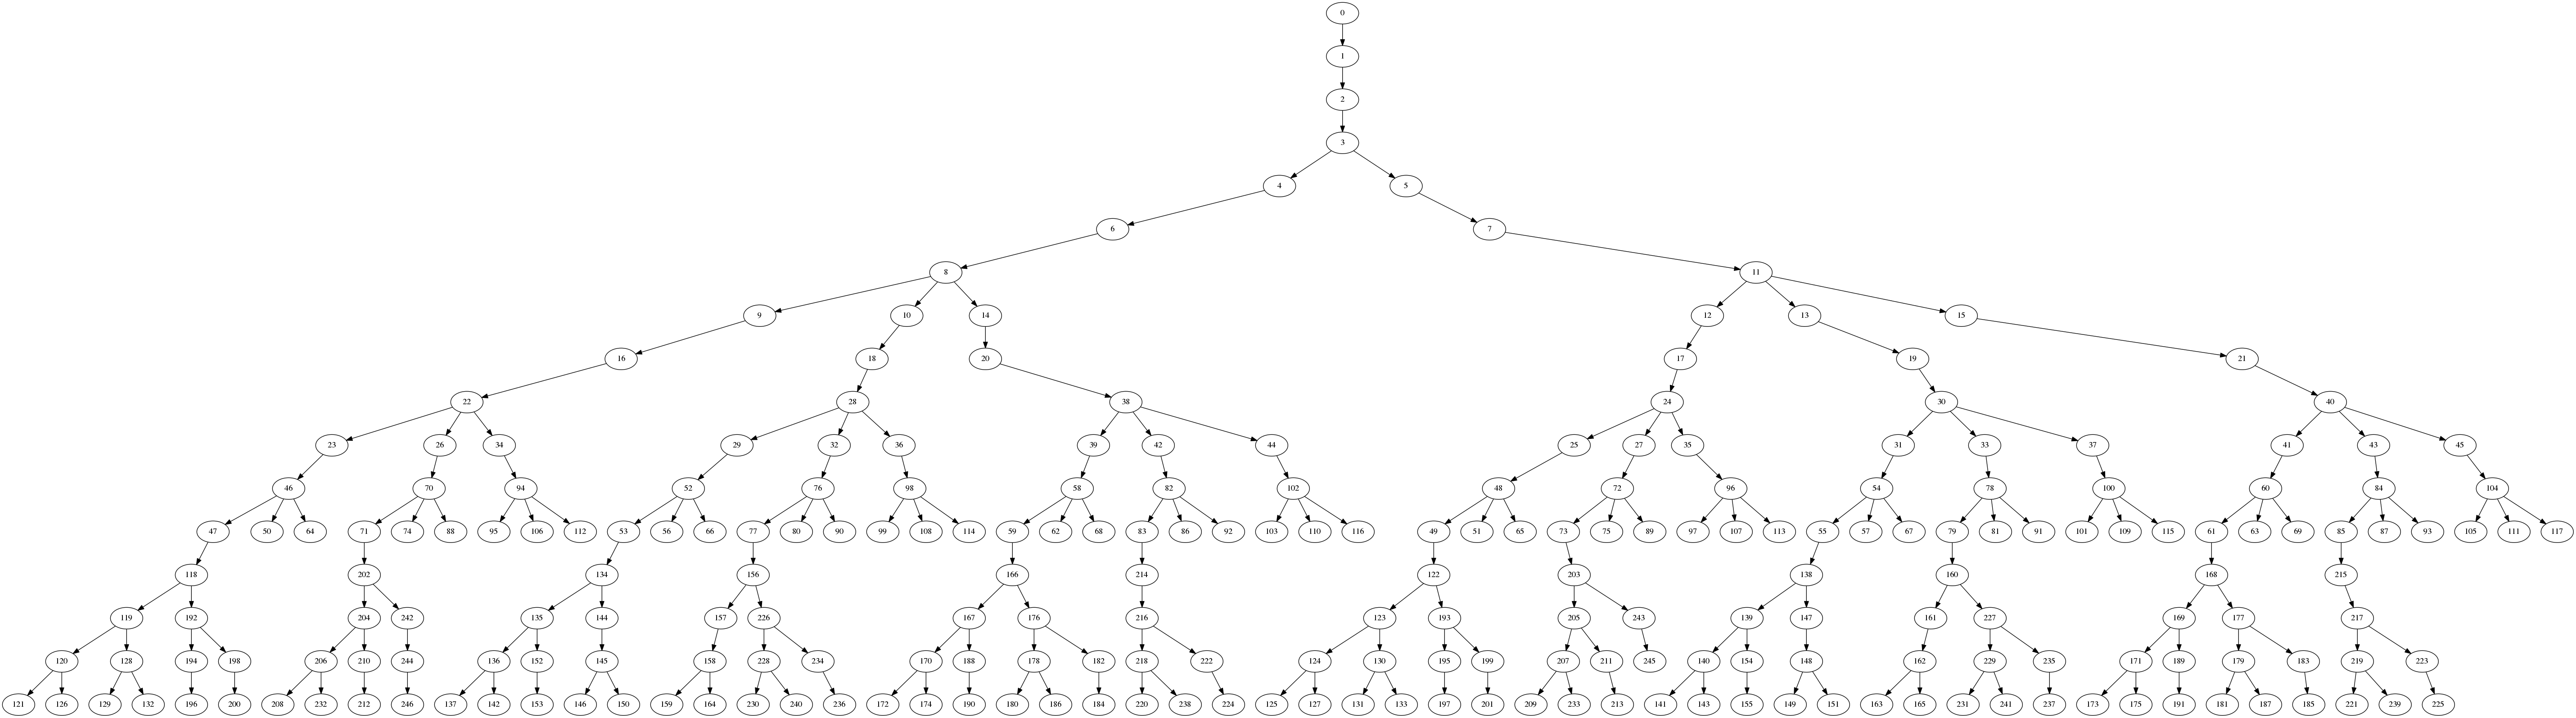

In [197]:
import networkx as nx
from IPython.display import Image

g=nx.DiGraph()
g.add_edges_from(app.tree.edges)
p=nx.drawing.nx_pydot.to_pydot(g)
p.write_png('example.png')

Image(filename='example.png') 

In [62]:
edges

AttributeError: 'list' object has no attribute 'shape'

In [12]:
%load_ext Cython

In [ ]:
""" 
clf = joblib.load('LinearClass')

model = load_model('zeros_policy_44')

"""


In [98]:
clf = joblib.load('LinearClass')

In [13]:
%%cython
cimport numpy as np




import numpy as np
from keras.models import load_model
from sklearn.externals import joblib
import tkinter
import random
from tkinter import *
import math
from copy import deepcopy
from time import time
import numba


model = load_model('zeros_policy_44')
clf = joblib.load('LinearClass')

class RenjuTEST(): 
    def __init__(self, player, mode):
        """
        player : 1 for black, 2 for white
        """
        self.cur_pos = np.zeros((15,15, 3))
        self.cur_player = 1
        self.player = player
        self.action_space = 225
        self.moves_done = 0
        self.ext_pos = np.zeros((25, 25))
        self.lr_pos = np.zeros(225)
        self.mode = mode
        

    def in_step(self, action):
        """
        Run one timestep of the environment's dynamics. When end of episode
        is reached, reset() should be called to reset the environment's internal state.
        Input
        -----
        action : an action provided by the environment
        Outputs
        -------
        (observation, reward, done, info)
        observation : agent's observation of the current environment
        reward [Float] : amount of reward due to the previous action
        done : a boolean, indicating whether the episode has ended
        info : a dictionary containing other diagnostic information from the previous action
        """
        self.moves_done += 1
        if self.cur_player == 1:
            self.cur_pos[action % 15][action // 15][0] = 1
            self.lr_pos[action] = 1
        else:
            self.cur_pos[action % 15][action // 15][1] = 1
            self.lr_pos[action] = 2
            
            
        w = (action % 15) + 5
        h = (action // 15) + 5
        
        self.ext_pos[w][h] = self.cur_player
        
        """
        for i in range(15):
            for j in range(15):
                if self.cur_pos[i][j][0] > 0 or self.cur_pos[i][j][1] > 0:
                    self.cur_pos[i][j][2] += 1
        """
        self.cur_pos[:, :, 2:] = self.cur_pos.sum(2).reshape((15,15,1))

        reward = 0
        
        rdiag = [0, 0, 0]
        rdiaginv = [0, 0, 0]
        ldiag = [0, 0, 0]
        ldiaginv = [0, 0, 0]
        rrow = [0, 0, 0]
        lrow = [0, 0, 0]
        rcol = [0, 0, 0]
        lcol = [0, 0, 0]
        
        broken = [0,0,0,0,0,0,0,0]
        
        for i in range(5):
            
            if self.ext_pos[w + i][h + i]:
                if not broken[0]:
                    rdiag[int(self.ext_pos[w + i][h + i])] += 1
                else:
                    broken[0] = 1
                
            if self.ext_pos[w][h + i]:
                if not broken[1]:
                    rcol[int(self.ext_pos[w][h + i])] += 1
                else:
                    broken[1] = 1
                
            if self.ext_pos[w - i][h + i]:
                if not broken[2]:
                    ldiag[int(self.ext_pos[w - i][h + i])] += 1
                else:
                    broken[2] = 1
                
            
            if self.ext_pos[w - i][h]:
                if not broken[3]:
                    lrow[int(self.ext_pos[w - i][h])] += 1
                else:
                    broken[3] = 1
            
            if self.ext_pos[w - i][h - i]:
                if not broken[4]:
                    rdiaginv[int(self.ext_pos[w - i][h - i])] += 1
                else:
                    broken[4] = 1
            
            if self.ext_pos[w][h - i]:
                if not broken[5]:
                    lcol[int(self.ext_pos[w][h - i])] += 1
                else:
                    broken[5] = 1
            
            if self.ext_pos[w + i][h - i]:
                if not broken[6]:
                    ldiaginv[int(self.ext_pos[w + i][h - i])] += 1
                else:
                    broken[6] = 1
            
            if self.ext_pos[w + i][h]:
                if not broken[7]:
                    rrow[int(self.ext_pos[w + i][h])] += 1
                else:
                    broken[7] = 1
        
        
        if rdiag[self.cur_player] + rdiaginv[self.cur_player] >= 6:
            if self.player == self.cur_player:
                reward = 1
            else:
                reward = -1
                
        if ldiag[self.cur_player] + ldiaginv[self.cur_player] >= 6:
            if self.player == self.cur_player:
                reward = 1
            else:
                reward = -1
        
        if rrow[self.cur_player] + lrow[self.cur_player] >= 6:
            if self.player == self.cur_player:
                reward = 1
            else:
                reward = -1
                
        if lcol[self.cur_player] + rcol[self.cur_player] >= 6:
            if self.player == self.cur_player:
                reward = 1
            else:
                reward = -1
        """
        print('rdiag', rdiag)
        print('rdiaginv', rdiaginv)
        print('ldiag', ldiag)
        print('ldiaginv', ldiaginv)
        print('rrow', rrow)
        print('lrow', lrow)
        print('rcol', rcol)
        print('lcol', lcol)
        """
        
        if self.cur_player == 1:
            self.cur_player = 2
        else:
            self.cur_player = 1
        
        done = True if (self.moves_done == 225 or reward != 0) else False
        cur_pos = self.cur_pos
        if self.moves_done == 225:
            self.reset()
        info = dict()
        return (cur_pos, reward, done, info)
    
    def net_ans(self, model, mode = 'all'):
        s = model.predict(np.array([[self.cur_pos]]))[0]
        if mode == 'one':
            return np.argmax(s)
        else:
            #return sorted(range(len(s)), key=lambda k: s[k], reverse=True)
            return np.argsort(s)
    
    def simulation(self, model, mode):
        fake_env = RenjuTEST(1, 'neural')
        fake_env.cur_pos = np.copy(self.cur_pos)
        fake_env.cur_player = self.cur_player
        fake_env.player = self.player
        fake_env.action_space = self.action_space = 225
        fake_env.moves_done = self.moves_done
        fake_env.ext_pos = np.copy(self.ext_pos)
        fake_env.lr_pos = np.copy(self.lr_pos)
        fake_env.mode = self.mode
        reward = 0
        while reward == 0:
            
            action = random.randint(0,224)
            while fake_env.cur_pos[action % 15][action // 15][0] != 0 or fake_env.cur_pos[action % 15][action // 15][1] != 0:
                action = random.randint(0,224)
                
            """ 
            #if mode == 'kn':
            s = clf.predict_proba([fake_env.lr_pos])[0]
            #else:
            #    s = model.predict(np.array([[fake_env.cur_pos]]))[0]
            action = np.argmax(s)
            if fake_env.cur_pos[action % 15][action // 15][0] != 0 or fake_env.cur_pos[action % 15][action // 15][1] != 0:
                net_move = np.argsort(s)[::-1]
                action = 0
                for act in net_move:
                    if fake_env.cur_pos[act % 15][act // 15][0] == 0 and fake_env.cur_pos[act % 15][act // 15][1] == 0:
                        action = act
                        break
            """
            cur_pos, reward, done, info = fake_env.in_step(action)
            
        if reward == 1:
            return 1
        else:
            return 0
    


    def step(self, action, mode = 'kn'):
        cur_pos, reward, done, info = self.in_step(action)

        if reward != 0:
            #self.render()
            if done:
                self.reset()
            return cur_pos, reward, done, info
        else:
            if self.mode == 'neural':
                s = model.predict(np.array([[self.cur_pos]]))[0]
            else:
                s = clf.predict_proba([self.lr_pos])[0]
            #plt.figure()
            #k = s.reshape((15,15))
            #plt.imshow(k, cmap='hot', interpolation='nearest')
            #plt.show()
            action = np.argmax(s)
            if self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
                net_move = np.argsort(s)[::-1]
                
                action = 0
                #print(net_move)
                for act in net_move:
                    if self.cur_pos[act % 15][act // 15][0] == 0 and self.cur_pos[act % 15][act // 15][1] == 0:
                        action = act
                        break
                #print("Net:", action)

            rnd = np.random.randint(1, 100)
            if rnd < -10:
                action = np.random.randint(0, 224)
                while self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
                    action = np.random.randint(0, 224)
            print('Net action:', action)
            cur_pos, reward, done, info = self.in_step(action)
            return cur_pos, reward, done, action
    
    def learning(self, opponent):
        if self.moves_done % 2 == 0:
            s = opponent.predict(np.array([[self.cur_pos]]))[0]
        else:
            s = model.predict(np.array([[self.cur_pos]]))[0]
        action = np.argmax(s)
        if self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
            net_move = np.argsort(s)[::-1]

            action = 0
            #print(net_move)
            for act in net_move:
                if self.cur_pos[act % 15][act // 15][0] == 0 and self.cur_pos[act % 15][act // 15][1] == 0:
                    action = act
                    break
            #print("Net:", action)
        rnd = np.random.randint(1, 100)
        if rnd < 5:
            action = np.random.randint(0, 224)
            while self.cur_pos[action % 15][action // 15][0] != 0 or self.cur_pos[action % 15][action // 15][1] != 0:
                action = np.random.randint(0, 224)

        cur_pos, reward, done, info = self.in_step(action)
        return cur_pos, reward, done, action
            
            
    
    def render(self, mode='human'):
        if mode == 'human':
            for j in reversed(range(15)):
                for i in range(15):
                    flag = 0
                    if self.cur_pos[i][j][0] == 1:
                        flag = 1
                        print("X", end=' ')
                    if self.cur_pos[i][j][1] == 1:
                        flag = 1
                        print("O", end=' ')
                    if not flag:
                        print("_", end=' ')
                print('\n', end='')
            print("------------------------------------------------\n")
        if mode == 'debug':
            for j in reversed(range(25)):
                for i in range(25):
                    flag = 0
                    if self.ext_pos[i][j] == 1:
                        flag = 1
                        print("X", end=' ')
                    if self.ext_pos[i][j] == 2:
                        flag = 1
                        print("O", end=' ')
                    if not flag:
                        print("_", end=' ')
                print('\n', end='')
            print("------------------------------------------------\n")
        
     
    def reset(self):
        """
        Resets the state of the environment, returning an initial observation.
        Outputs
        -------
        observation : the initial observation of the space. (Initial reward is assumed to be 0.)
        """
        self.cur_pos = np.zeros((15,15,3))
        self.cur_player = 1
        self.moves_done = 0
        self.ext_pos = np.zeros((25, 25))
        self.lr_pos = np.zeros(225)
        return self.cur_pos


class MCSTNode():
    def __init__(self, env):
        self.wins = 0
        self.all_games = 0
        self.childs = []
        self.env = env
        self.parent = None
        self.action = None
        self.index = np.random.randint(0, 10000000)
        self.child_actions = []
       

class UCT():
    def __init__(self, env, model, mode):        
        self.root = MCSTNode(env)
        self.all_games = 0
        self.constant = math.sqrt(2)
        self.cur_node = self.root
        self.model = model
        self.cur_pos = self.root
        self.mode = mode

    
    def get_child_UCT_list(self, node):
        return list(map(self.get_UCT_stat, node.childs))
       
    def explore(self):
        self.cur_node = self.root
        UCT_list = self.get_child_UCT_list(self.cur_node)
        while len(UCT_list) > 0 and  max(UCT_list) > self.get_UCT_stat(self.cur_node):
            #print(UCT_list, "I am at ", self.cur_node.index)
            #print(UCT_list)
            best_node = np.argmax(UCT_list)
            self.cur_node = self.cur_node.childs[best_node]
            UCT_list = self.get_child_UCT_list(self.cur_node)
    
    def expand(self):
        if self.cur_node.all_games > 1:
            #if self.mode == 'kn':
                #s = clf.predict_proba([self.cur_node.env.lr_pos])[0]
            #else:
            s = model.predict(np.array([[self.cur_node.env.cur_pos]]))[0]
            action = np.argmax(s)
            if self.cur_node.env.cur_pos[action % 15][action // 15][0] != 0 or self.cur_node.env.cur_pos[action % 15][action // 15][1] != 0:
                net_move = np.argsort(s)[::-1]
                action = 0
                for act in net_move:
                    if act not in self.cur_node.child_actions and self.cur_node.env.cur_pos[act % 15][act // 15][0] == 0 and self.cur_node.env.cur_pos[act % 15][act // 15][1] == 0:
                        action = act
                        break        

            new_node_action = action
            #print('New Node!')

            new_env = deepcopy(self.cur_node.env)
            new_env.in_step(new_node_action)

            new_node = MCSTNode(new_env)
            new_node.parent = self.cur_node
            new_node.action = new_node_action
            self.cur_node.child_actions.append(new_node_action)

            run = new_node.env.simulation(self.model, self.mode)
            self.all_games += 1

            self.cur_node.childs.append(new_node)
            self.cur_node = new_node

            while(self.cur_node.parent != None):
                self.cur_node.wins += run
                self.cur_node.all_games += 1
                self.cur_node = self.cur_node.parent
            else:
                self.cur_node.wins += run
                self.cur_node.all_games += 1
        else:
            run = self.cur_node.env.simulation(self.model, self.model)
            self.all_games += 1

            while(self.cur_node.parent != None):
                self.cur_node.wins += run
                self.cur_node.all_games += 1
                self.cur_node = self.cur_node.parent
            else:
                self.cur_node.wins += run
                self.cur_node.all_games += 1
            
            
    def search(self, time_limit):
        begin = time()
        while (time() - begin) < time_limit * 0.95:
            self.explore()
            self.expand()
        root_values = list(map(self.get_stat, self.root.childs))
        #print(root_UCT_values, len(self.root.childs))
        if len(root_values) != 0:
            best_child = np.argmax(root_values)
        else:
            self.root = self.root.childs[0]
            return self.root.action
        self.root = self.root.childs[best_child]
        return self.root.action
                    
    def get_UCT_stat(self, node):
        if node.all_games == 0:
            return 0
        else:
            return float(node.wins) / float(node.all_games) + self.constant * math.sqrt(math.log(self.all_games / node.all_games))
    
    def get_stat(self, node):
        if node.all_games == 0:
            return 0
        else:
            return float(node.wins) / float(node.all_games)


class my_app(Frame):
    """Basic Frame"""
    def __init__(self, master, mode, time_for_search):
        self.buttons = []
        """Init the Frame"""
        Frame.__init__(self,master)
        self.grid()
        self.Create_Widgets()
        self.tester = RenjuTEST(2 if mode == 'me' else 1, mode)
        self.label = tkinter.Label(self, text='')
        self.label.grid(column=7, row=16, sticky=W);   #creates label for image on window 
        self.tree = UCT(self.tester, model, mode)
        self.mode = mode
        self.time_for_search = time_for_search

    
    def Create_Widgets(self):
        for i in range(15):
            for j in range(15): #Start creating buttons

                button_id = i * 15 + j 
                #print(self.button_id)

                self.newmessage = Button(self, #I want to bind the self.button_id to each button, so that it prints its number when clicked.
                                         text = '',
                                         anchor = W, command = lambda button_id=button_id: self.access(button_id))#Run the method

                #Placing
                self.newmessage.config(height = 1, width = 1)
                self.newmessage.grid(row = 15 - i, column = j, sticky = NW)
                self.buttons.append(self.newmessage)
      
    def access(self, b_id): #This is one of the areas where I need help. I want this to return the number of the button clicked.
        self.b_id = b_id
        print(b_id)
        self.buttons[b_id].config(text = 'X' if self.tester.cur_player == 1 else 'O')
        
        """ 
        cur_pos, reward, done, info = self.tester.step(b_id)
        self.tester.render(mode='human')
        
        self.buttons[info].config(text = 'X' if self.tester.cur_player == 2 else 'O')
        
        #""" 
        cur_pos, reward, done, info = self.tester.in_step(b_id)
        
        #self.tester.render(mode='human')
        if reward != 0:
            ch = 'X' if self.tester.cur_player == 2 else 'O'
            self.label.config(text = str(ch + ' win'))
        
        if b_id in self.tree.root.child_actions:
            for node in self.tree.root.childs:
                if node.action == b_id:
                    self.tree.root = node
                    break
        else:
            self.tree = UCT(self.tester, model, self.mode)
        #tree = UCT(self.tester, model, 'kn' if random.randint(0,1) == 0 else 'neuron')
        tree_act = self.tree.search(self.time_for_search)
        print(self.tree.root.all_games, tree_act)
        #print(tree_act, tree.root.all_games)
        self.buttons[tree_act].config(text = 'X' if self.tester.cur_player == 1 else 'O')
        cur_pos, reward, done, info = self.tester.in_step(tree_act)
        #self.tester.render(mode='human')
        if reward != 0:
            ch = 'X' if self.tester.cur_player == 2 else 'O'
            self.label.config(text = str(ch + ' win'))
        #"""
        

opponent = 'neural'
first_move = 'me'
time_for_search = 10



root = Tk()
root.title("Tic-Tac-Toe")
root.geometry("542x500")
app = my_app(root, opponent, time_for_search)


if first_move != 'me':
    tree_act = app.tree.search(time_for_search)
    #print(tree_act, tree.root.all_games)
    app.buttons[tree_act].config(text = 'X' if app.tester.cur_player == 1 else 'O')
    cur_pos, reward, done, info = app.tester.in_step(tree_act)

root.mainloop()

112
4111 127
142
3906 129
157
4381 126


In [38]:
%%timeit
s = clf.predict([tester_1.lr_pos])[0]

62.7 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
np.nonzero(tester_1.lr_pos)

(array([95]),)

In [37]:
%%timeit
s = model.predict(np.array([[tester_1.cur_pos]]))[0]

1.74 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
from tqdm import tqdm

tester_1 = RenjuTEST(1, 'neural')
tester_2 = RenjuTEST(2, 'kn')

win = 0
loose = 0
all_game = 0

mode_1 = 'kn'
mode_2 = 'neuron'

tree_1 = UCT(tester_1, model, mode_1)
tree_2 = UCT(tester_2, model, mode_2)

for i in tqdm(range(150)):
    
    tree_act = tree_1.search(5)
    print(tree_act, tree_1.root.all_games)
    cur_pos, reward, done, info = tester_1.in_step(tree_act)
    tester_2.in_step(tree_act)
    
    if tree_act in tree_2.root.child_actions:
        for node in tree_2.root.childs:
            if node.action == tree_act:
                tree_2.root = node
                break
    else:
        tree_2 = UCT(tester_2, model, mode_2)
        
        
    if reward == 1:
        win += 1
        all_game += 1
    if reward == -1:
        loose += 1
        all_game += 1
        
    
    tree_act = tree_2.search(5)
    print(tree_act, tree_2.root.all_games)
    cur_pos, reward, done, info = tester_2.in_step(tree_act)
    tester_1.in_step(tree_act)
    if tree_act in tree_1.root.child_actions:
        for node in tree_1.root.childs:
            if node.action == tree_act:
                tree_1.root = node
                break
    else:
        tree_1 = UCT(tester_1, model, mode_1)
        
    if reward == -1:
        win += 1
        all_game += 1
    if reward == 1:
        loose += 1
        all_game += 1
        
    #tester.render(mode='human')

  0%|          | 0/150 [00:00<?, ?it/s]

95 2006


KeyboardInterrupt: 

In [364]:
print("win:", win, "loose:", loose, "all rate:", win / all_game)

win: 7 loose: 12 all rate: 0.3684210526315789


In [52]:
%lprun -f  tester.step tester.step(1)

In [32]:
indices

(array([0]), array([3]))

In [22]:
np.argmax(model_check_env.predict(np.array([[env.cur_pos]])))

205

In [55]:
def net_ans(env):
    s = model_check_env.predict(np.array([[env.cur_pos]]))[0]
    return sorted(range(len(s)), key=lambda k: s[k], reverse=True)

net_ans(env)

[205,
 157,
 79,
 191,
 63,
 202,
 22,
 175,
 111,
 91,
 189,
 152,
 142,
 34,
 25,
 160,
 72,
 33,
 204,
 36,
 176,
 19,
 57,
 48,
 137,
 178,
 133,
 52,
 136,
 106,
 151,
 132,
 77,
 187,
 102,
 103,
 92,
 26,
 118,
 88,
 20,
 42,
 109,
 35,
 67,
 172,
 121,
 126,
 78,
 93,
 119,
 169,
 61,
 39,
 177,
 153,
 71,
 24,
 148,
 59,
 201,
 18,
 162,
 107,
 161,
 104,
 139,
 122,
 146,
 64,
 62,
 190,
 127,
 186,
 194,
 199,
 41,
 167,
 198,
 74,
 166,
 56,
 124,
 40,
 215,
 131,
 134,
 174,
 159,
 164,
 51,
 182,
 87,
 117,
 37,
 140,
 110,
 155,
 185,
 168,
 76,
 54,
 171,
 154,
 7,
 206,
 49,
 193,
 149,
 73,
 90,
 123,
 163,
 31,
 147,
 183,
 192,
 138,
 108,
 58,
 89,
 4,
 170,
 65,
 69,
 116,
 70,
 94,
 145,
 66,
 47,
 50,
 184,
 200,
 44,
 21,
 5,
 2,
 27,
 86,
 125,
 80,
 105,
 97,
 101,
 209,
 141,
 156,
 220,
 179,
 181,
 55,
 17,
 75,
 208,
 43,
 219,
 216,
 30,
 14,
 96,
 6,
 223,
 46,
 120,
 150,
 32,
 12,
 213,
 135,
 212,
 217,
 95,
 195,
 222,
 15,
 3,
 196,
 10,
 214,
 13,

In [6]:
for i in range(len(model_normal.layers)):
    model.layers[i + 1].set_weights(model_normal.layers[i].get_weights())

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Convolution2D, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.layers import GRU, LSTM

model_policy = Sequential()

model_policy.add(Reshape((15,15,3), input_shape=(1,15,15,3)))
model_policy.add(Convolution2D(8, (3,3), input_shape=(15, 15, 4), activation='relu'))

model_policy.add(Flatten(name='flatten'))


model_policy.add(Dense(550, activation='relu', name='fc1'))

model_policy.add(Dense(225, activation='softmax', name='fc2'))
model_policy.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_policy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 15, 15, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 8)         224       
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 550)               744150    
_________________________________________________________________
fc2 (Dense)                  (None, 225)               123975    
Total params: 868,349.0
Trainable params: 868,349.0
Non-trainable params: 0.0
_________________________________________________________________


In [19]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.agents.sarsa import SarsaAgent


ENV_NAME = 'Renju'


# Get the environment and extract the number of actions.
env = RenjuTEST(1, 'kn')
np.random.seed(123)
nb_actions = 225

memory = SequentialMemory(limit=1000000, window_length=1)


policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=10000)


dqn = DQNAgent(model=model_policy, nb_actions=nb_actions, policy=policy, memory=memory,
                nb_steps_warmup=5000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])


In [20]:
dqn.fit(env, nb_steps=175000, log_interval=10000, verbose = 2 )

# After training is done, we save the final weights one more time.
dqn.save_weights('latest_dqn', overwrite=True)

# Finally, evaluate our algorithm for 10 episodes.
dqn.test(env, nb_episodes=1, visualize=True)
dqn.test(env, nb_episodes=10, visualize=False)

Training for 175000 steps ...
     56/175000: episode: 1, duration: 0.512s, episode steps: 56, steps per second: 109, episode reward: -1.000, mean reward: -0.018 [-1.000, 0.000], mean action: 117.411 [3.000, 222.000], mean observation: 1.602 [0.000, 112.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --
     87/175000: episode: 2, duration: 0.150s, episode steps: 31, steps per second: 206, episode reward: 1.000, mean reward: 0.032 [0.000, 1.000], mean action: 129.194 [1.000, 219.000], mean observation: 0.564 [0.000, 61.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --
    124/175000: episode: 3, duration: 0.186s, episode steps: 37, steps per second: 199, episode reward: 1.000, mean reward: 0.027 [0.000, 1.000], mean action: 109.162 [3.000, 224.000], mean observation: 0.784 [0.000, 73.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --
    152/175000: episode: 4, duration: 0.213s, episode steps: 28, steps per second: 132, episode reward: 1.00

In [26]:
sarsa = SarsaAgent(model=model_policy, nb_actions=225)
sarsa.compile(Adam(), metrics=['mae'])

In [27]:
sarsa.load_weights("sarsa_Renju9_weights.h5f")

In [28]:
env = RenjuTEST(1, 'kn')

In [22]:
for epoch in range(10000):
    dqn.fit(env, nb_steps=17500, log_interval=10000, verbose = 0 )

    # After training is done, we save the final weights.
    dqn.save_weights('dqn', overwrite=True)

    # Finally, evaluate our algorithm for 5 episodes.
    dqn.test(env, nb_episodes=1, visualize=True)
    env = RenjuTEST(1, 'kn' if random.randint(0,1) == 0 else 'neural')
    dqn.test(env, nb_episodes=10, visualize=False)
    print('Opponent:', env.mode)

Testing for 1 episodes ...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ O _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ X _ 
------------------------------------------------

_ _ _ _ _ _ _ _ _ _ O _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ O _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ 

KeyboardInterrupt: 